In [13]:
import numpy as np
import os
from tqdm import tqdm

source = os.walk('./HW3')

# for folder, subfolder, file in source:
#     print(folder,subfolder,file) 

filepath = [folder + '/' + filename for folder, _ , file in source for filename in file] 
test = np.load(filepath[0])
train_inner_break = np.load(filepath[1])
train_normal = np.load(filepath[2]) 
train_outer_break = np.load(filepath[3])

train_normal.shape

(250, 10240)

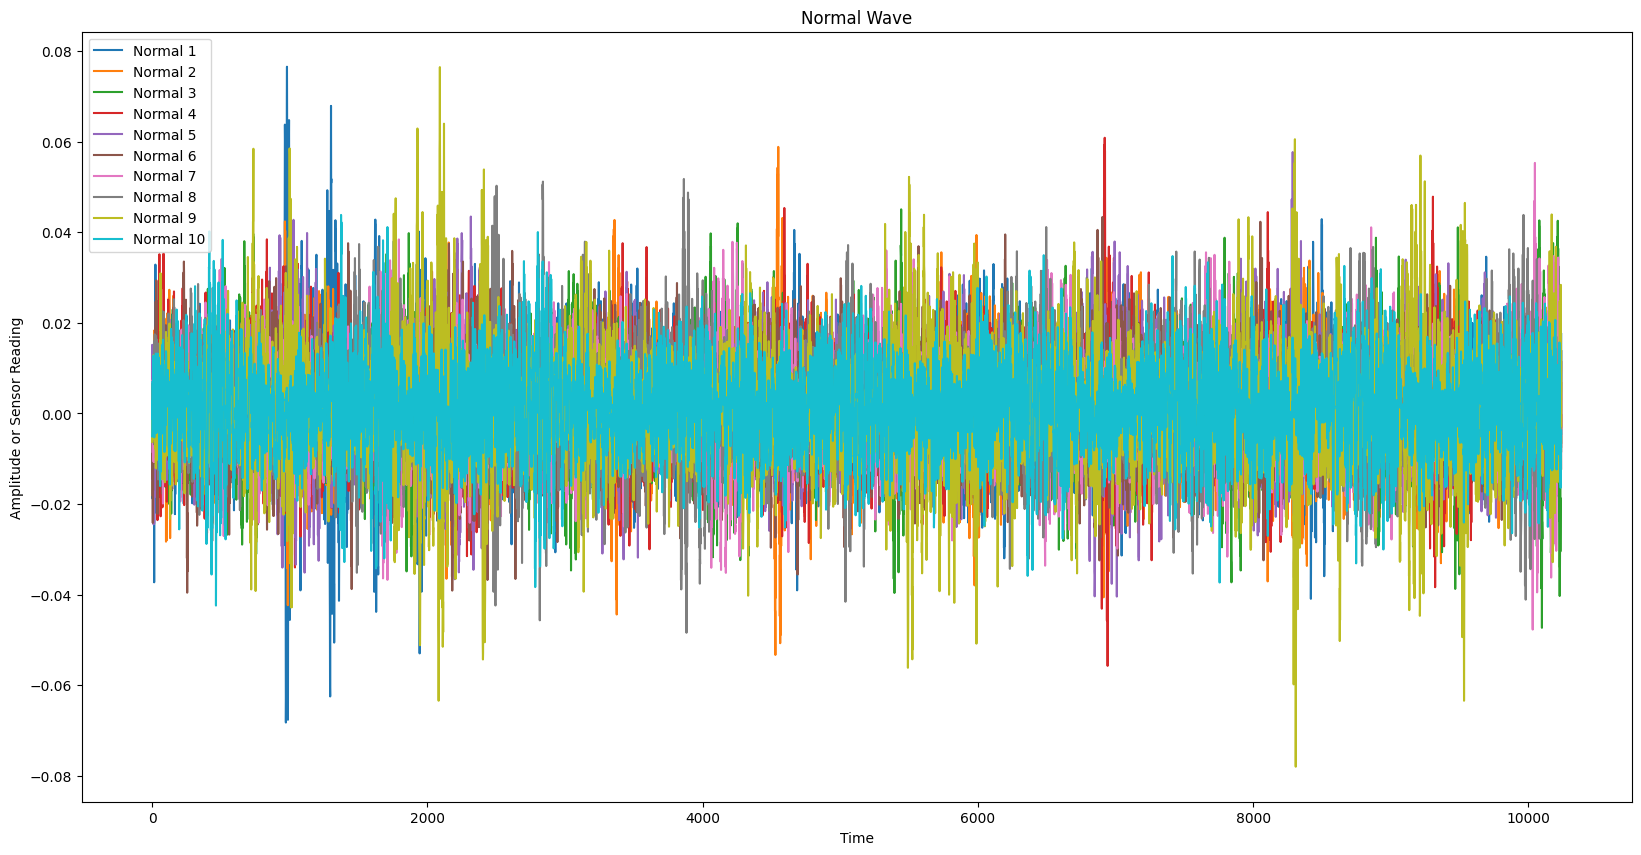

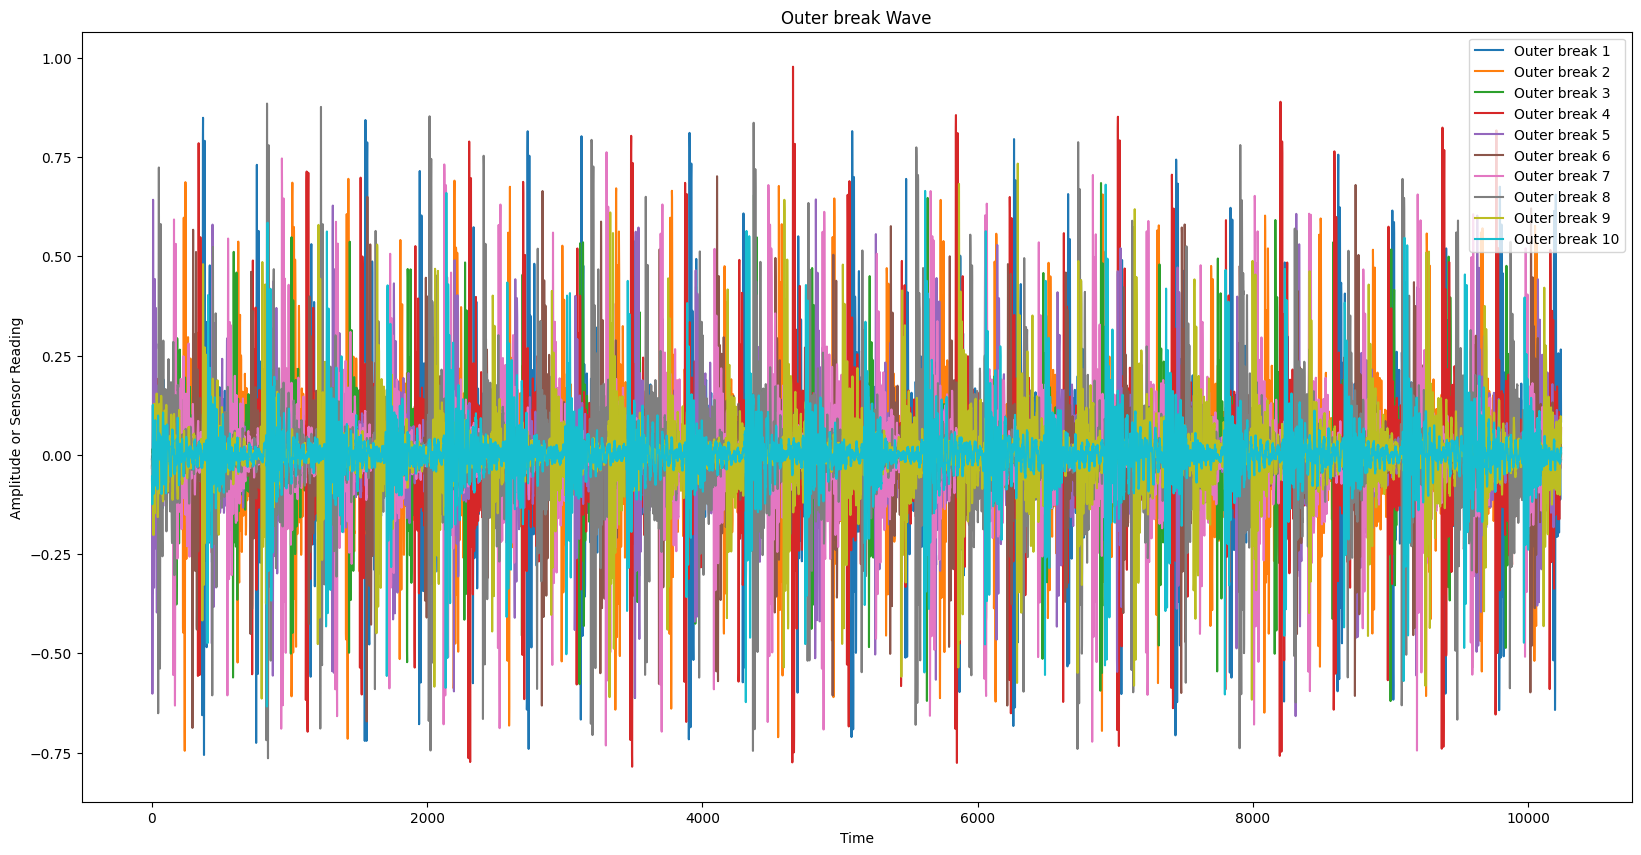

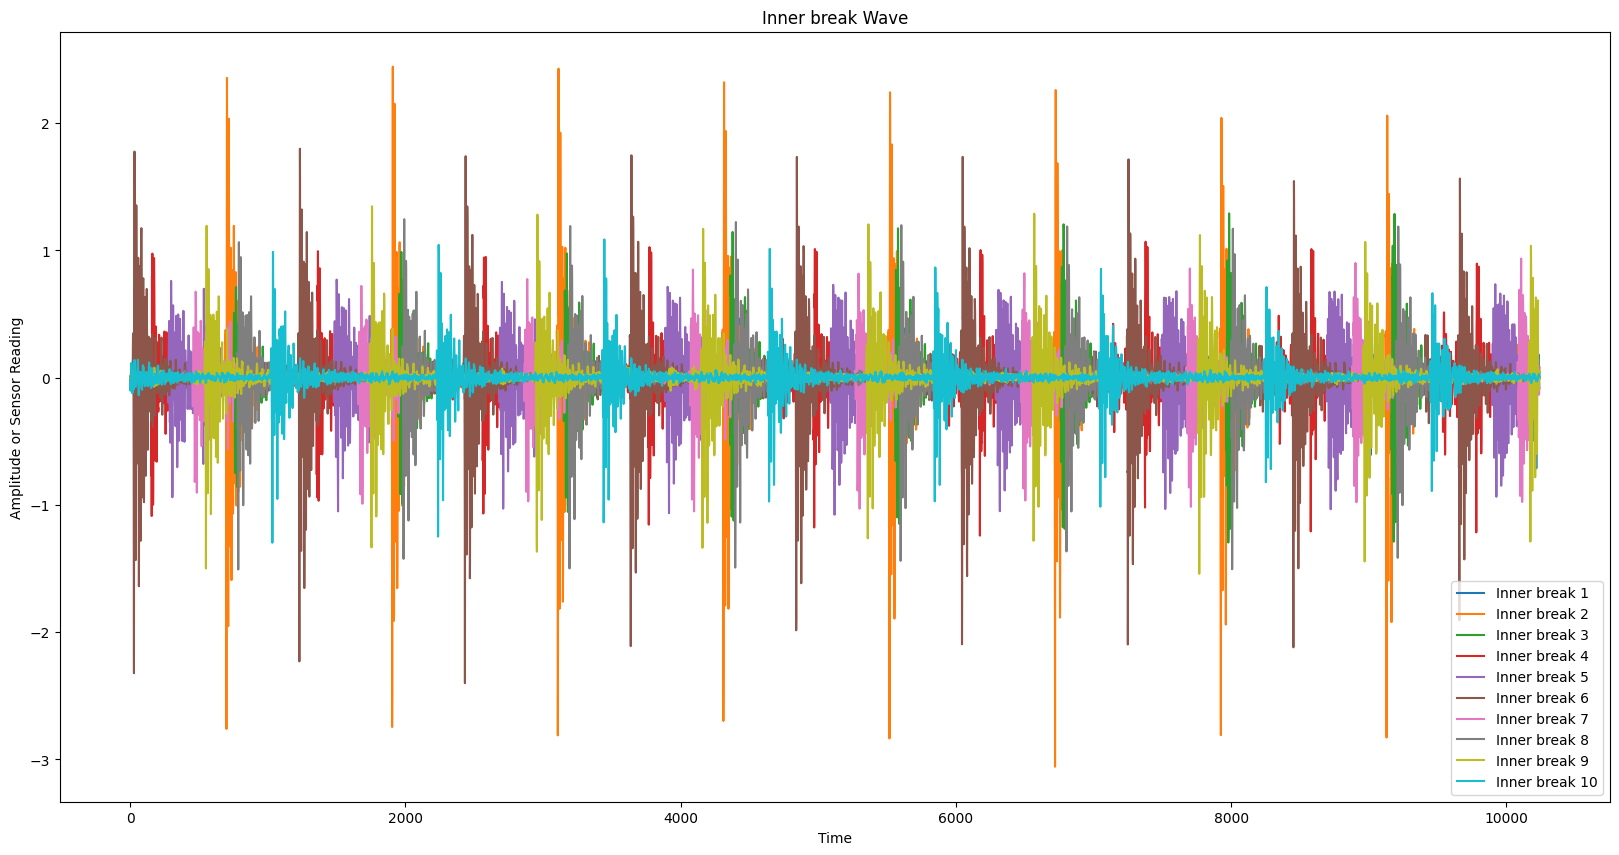

In [14]:
import matplotlib.pyplot as plt

x_axis = np.arange(10240)
smaple_num = 10

plt.figure(figsize=(20, 10))
for i in range(smaple_num):
    plt.plot(x_axis, train_normal[i], label=f'Normal {i+1}')
    
plt.title('Normal Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude or Sensor Reading')
plt.legend()
plt.show()



plt.figure(figsize=(20, 10))
for i in range(smaple_num):
    plt.plot(x_axis, train_outer_break[i], label=f'Outer break {i+1}')

plt.title('Outer break Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude or Sensor Reading')
plt.legend()
plt.show()



plt.figure(figsize=(20, 10))
for i in range(smaple_num):
    plt.plot(x_axis, train_inner_break[i], label=f'Inner break {i+1}')

plt.title('Inner break Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude or Sensor Reading')
plt.legend()
plt.show()


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

# def assign_labels(data, labels):
#     labels = np.full((data.shape[0],), labels)
#     return np.hstack((data, labels.reshape(-1,1)))

class WaveDataset(Dataset):
    def __init__(self, wave ,train = False, val = False, samplenum = 0):
        self.data = torch.tensor(wave[:,:], dtype=torch.float32)
        self.train = train
        self.val = val

        if self.train and self.val:
            self.labels = torch.tensor(np.concatenate((
                np.zeros(samplenum),
                np.ones(samplenum),
                np.ones(samplenum) * 2
            )),dtype=torch.long)
        
        elif self.train:
            self.labels = torch.tensor(np.concatenate((
                np.zeros(250),
                np.ones(250),
                np.ones(250)*2
            )),dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.train:
            return self.data[idx], self.labels[idx]
        else:
            return self.data[idx] 

val_split_flag = True
val_rate = 0.3
split_num = int(250*(1-val_rate))

if val_split_flag:
    training_set = np.concatenate((train_normal[:split_num], train_outer_break[:split_num], train_inner_break[:split_num]))  
    training_set = WaveDataset(training_set, train = True, val = True, samplenum= split_num)
    train_loader = DataLoader(training_set, batch_size = 32, shuffle = True)
    val_set = np.concatenate((train_normal[split_num:], train_outer_break[split_num:], train_inner_break[split_num:]))
    val_set = WaveDataset(val_set, train = True, val = True, samplenum = 250 - split_num)
    val_loader = DataLoader(val_set, batch_size = 32, shuffle = True) 
else:
    training_set = np.concatenate((train_normal,train_outer_break,train_inner_break))
    training_set = WaveDataset(training_set, train = True, val = False)
    train_loader = DataLoader(training_set, batch_size = 32, shuffle = True)

test_set = WaveDataset(test)
test_loader = DataLoader(test_set, batch_size = 32, shuffle = True) 


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(2)
        #self.conv2 = nn.Conv1d(16, 32, 5, stride=1, padding=0)
        #self.bn2 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size=1) 
        self.fc1 = nn.Linear(2 * 1, 3)  
        #self.fc2 = nn.Linear(128, 3)  

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        x = self.adaptive_pool(x)  # Adaptive average pooling to get a fixed size output
        x = x.view(-1, 2*1)  # Flatten the tensor
        #x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x


model = MyCNN()

print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")



MyCNN(
  (conv1): Conv1d(1, 2, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=2, out_features=3, bias=True)
)
Total number of trainable parameters: 29


In [19]:
from torchvision import models
from torchvision.models.resnet import BasicBlock, ResNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class BasicBlock1d(BasicBlock):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock1d, self).__init__(
            inplanes, planes, stride, downsample, groups, base_width, dilation, norm_layer)
        
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1,
                               padding=1, groups=groups, bias=False, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = nn.Sequential(
                nn.Conv1d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * self.expansion),
            )
        self.stride = stride

class ResNet1d(ResNet):
    def __init__(self, block, layers, num_classes=3, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet1d, self).__init__(block, layers, num_classes, zero_init_residual,
                                        groups, width_per_group, replace_stride_with_dilation,
                                        norm_layer)
        
        

        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

def _resnet1d(block, layers, **kwargs):
    model = ResNet1d(block, layers, **kwargs)
    return model

def resnet18_1d(**kwargs):
    return _resnet1d(BasicBlock1d, [2, 2, 2, 2], **kwargs)

model = resnet18_1d()
print("device:",device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")
model.to(device)


device: cuda:0
Total number of trainable parameters: 4199747


ResNet1d(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock1d(
      (conv1): Conv1d(64, 64,

In [20]:
# training


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    
    
    for inputs, labels in tqdm(train_loader, desc = f'train_samples:{len(train_loader.dataset)}'):

        inputs = inputs.unsqueeze(1).to(device)  # (batch_size, channels, length)
        labels = labels.to(device)
        

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], phase: train, Loss: {train_loss:.4f}, Train_Accuracy: {train_acc:.2f}%')

    if val_split_flag:
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader,desc = f'val_samples:{len(val_loader.dataset)}'):

                inputs = inputs.unsqueeze(1).to(device)  # (batch_size, channels, length)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = running_loss / len(val_loader) 
            val_acc = 100 * correct / total
            print(f'Epoch [{epoch+1}/{num_epochs}], phase: val, Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.2f}%')
        
            val_losses.append(val_loss)
            val_accs.append(val_acc)



print('Finished Training')

train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 11.93it/s]


Epoch [1/25], phase: train, Loss: 0.1959, Train_Accuracy: 91.24%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 44.20it/s]


Epoch [1/25], phase: val, Loss: 4.2472, Val_Accuracy: 33.33%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Epoch [2/25], phase: train, Loss: 0.0133, Train_Accuracy: 99.81%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.04it/s]


Epoch [2/25], phase: val, Loss: 3.7324, Val_Accuracy: 33.33%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.06it/s]


Epoch [3/25], phase: train, Loss: 0.0026, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.22it/s]


Epoch [3/25], phase: val, Loss: 0.5448, Val_Accuracy: 67.56%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.11it/s]


Epoch [4/25], phase: train, Loss: 0.0012, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.57it/s]


Epoch [4/25], phase: val, Loss: 0.4546, Val_Accuracy: 76.89%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.08it/s]


Epoch [5/25], phase: train, Loss: 0.1022, Train_Accuracy: 98.67%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 44.52it/s]


Epoch [5/25], phase: val, Loss: 0.0060, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.08it/s]


Epoch [6/25], phase: train, Loss: 0.0380, Train_Accuracy: 99.05%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.47it/s]


Epoch [6/25], phase: val, Loss: 0.0021, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.10it/s]


Epoch [7/25], phase: train, Loss: 0.0057, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.26it/s]


Epoch [7/25], phase: val, Loss: 0.0065, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.04it/s]


Epoch [8/25], phase: train, Loss: 0.0020, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.06it/s]


Epoch [8/25], phase: val, Loss: 0.0024, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.08it/s]


Epoch [9/25], phase: train, Loss: 0.0012, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.47it/s]


Epoch [9/25], phase: val, Loss: 0.0004, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.09it/s]


Epoch [10/25], phase: train, Loss: 0.0011, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.04it/s]


Epoch [10/25], phase: val, Loss: 0.0004, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Epoch [11/25], phase: train, Loss: 0.0008, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.26it/s]


Epoch [11/25], phase: val, Loss: 0.0004, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.06it/s]


Epoch [12/25], phase: train, Loss: 0.0004, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.06it/s]


Epoch [12/25], phase: val, Loss: 0.0002, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.07it/s]


Epoch [13/25], phase: train, Loss: 0.0004, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.08it/s]


Epoch [13/25], phase: val, Loss: 0.0001, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.09it/s]


Epoch [14/25], phase: train, Loss: 0.0004, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.00it/s]


Epoch [14/25], phase: val, Loss: 0.0002, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Epoch [15/25], phase: train, Loss: 0.0002, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.02it/s]


Epoch [15/25], phase: val, Loss: 0.0002, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.07it/s]


Epoch [16/25], phase: train, Loss: 0.0003, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.48it/s]


Epoch [16/25], phase: val, Loss: 0.0002, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.08it/s]


Epoch [17/25], phase: train, Loss: 0.0003, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 44.96it/s]


Epoch [17/25], phase: val, Loss: 0.0001, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.04it/s]


Epoch [18/25], phase: train, Loss: 0.0004, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.07it/s]


Epoch [18/25], phase: val, Loss: 0.0001, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.09it/s]


Epoch [19/25], phase: train, Loss: 0.0002, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.23it/s]


Epoch [19/25], phase: val, Loss: 0.0001, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.09it/s]


Epoch [20/25], phase: train, Loss: 0.0003, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.05it/s]


Epoch [20/25], phase: val, Loss: 0.0001, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.08it/s]


Epoch [21/25], phase: train, Loss: 0.0001, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.34it/s]


Epoch [21/25], phase: val, Loss: 0.0001, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.09it/s]


Epoch [22/25], phase: train, Loss: 0.0001, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 44.99it/s]


Epoch [22/25], phase: val, Loss: 0.0000, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.04it/s]


Epoch [23/25], phase: train, Loss: 0.0002, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.41it/s]


Epoch [23/25], phase: val, Loss: 0.0000, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.09it/s]


Epoch [24/25], phase: train, Loss: 0.0005, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 45.09it/s]


Epoch [24/25], phase: val, Loss: 0.0002, Val_Accuracy: 100.00%


train_samples:525: 100%|██████████| 17/17 [00:01<00:00, 12.07it/s]


Epoch [25/25], phase: train, Loss: 0.0005, Train_Accuracy: 100.00%


val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 44.88it/s]

Epoch [25/25], phase: val, Loss: 0.0001, Val_Accuracy: 100.00%
Finished Training


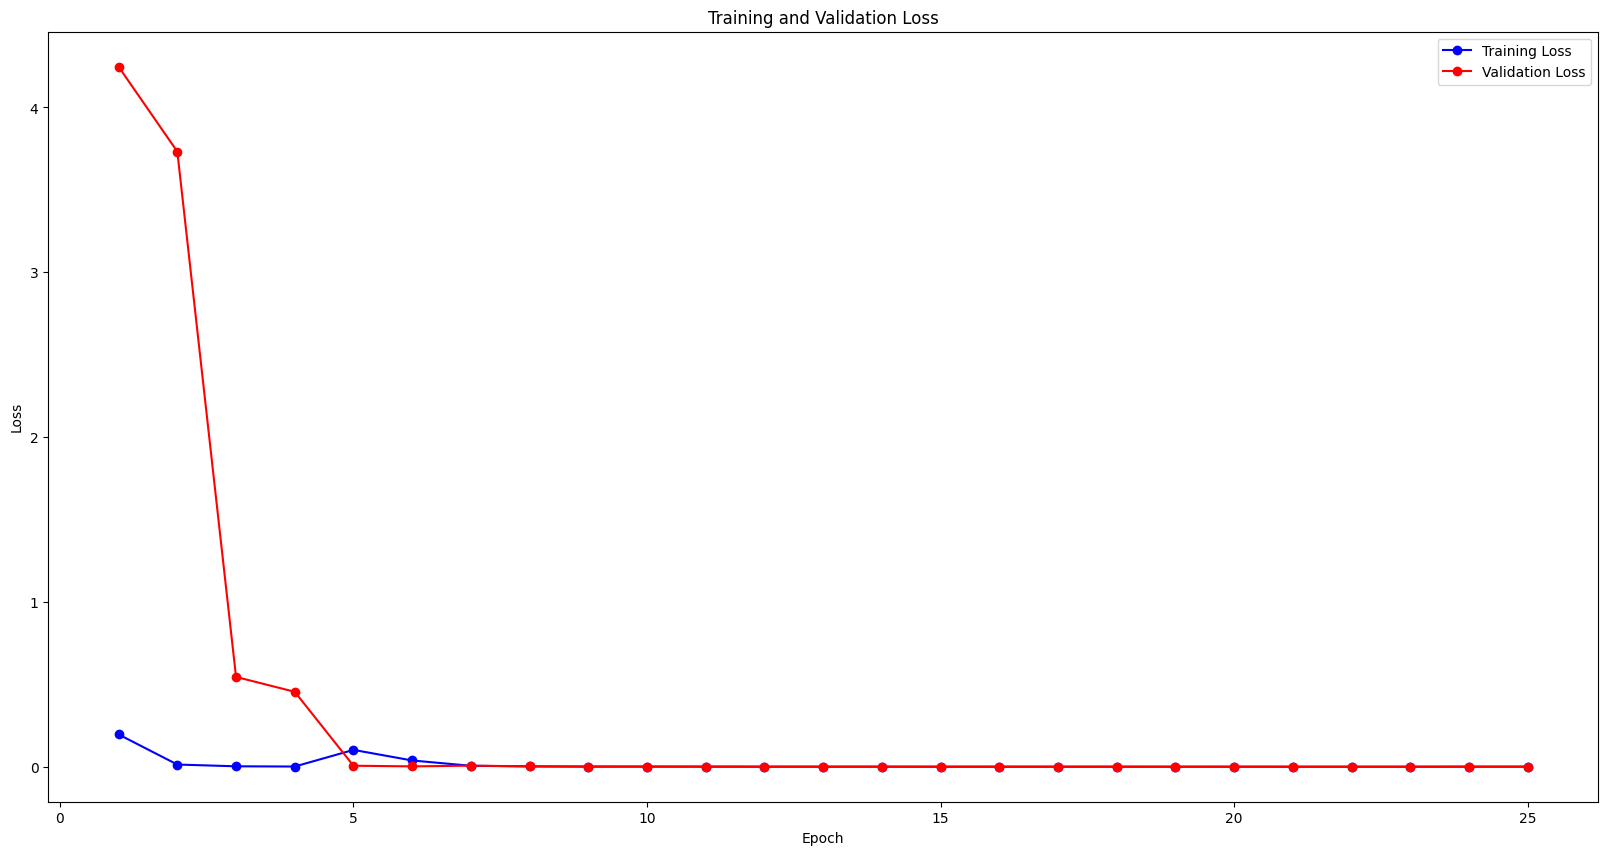

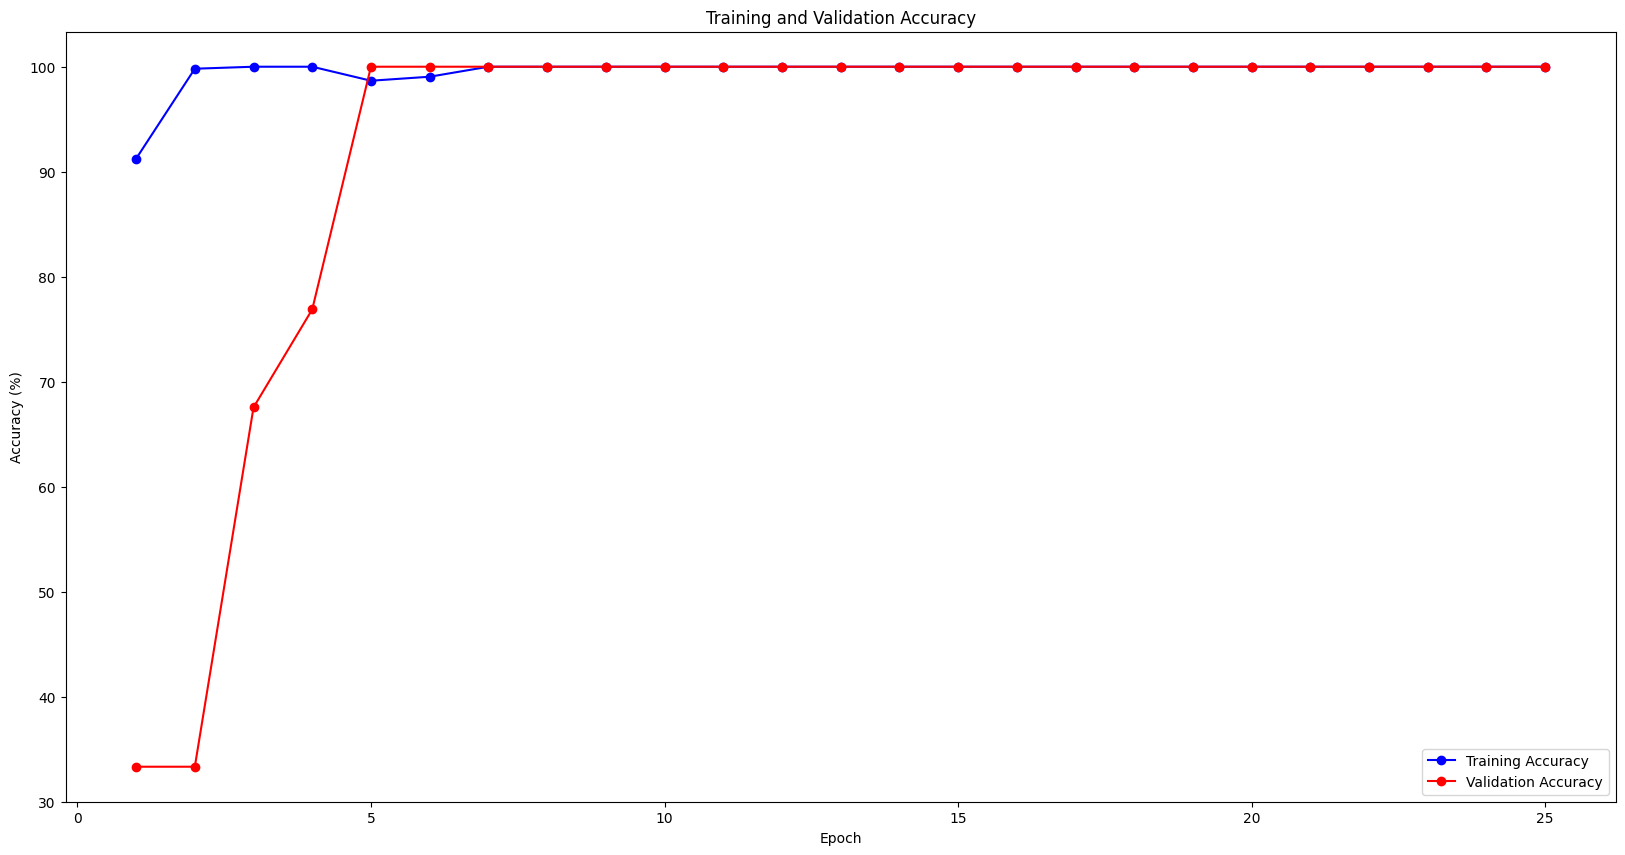

In [21]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(20, 10))
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(20, 10))
plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [22]:
import pandas as pd

# define label mapping
label_mapping = {0: 'normal', 1: 'outer_break', 2: 'inner_break' }

predictions = []
with torch.no_grad():
    for data in tqdm(test_loader,desc = 'Predicting'):
        inputs = data

        inputs = inputs.unsqueeze(1).to(device)  #  (batch_size, channels, length)
        
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())


string_predictions = [label_mapping[pred] for pred in predictions]

df = pd.DataFrame(string_predictions)
df.to_csv('./HW3.csv', header = False ,index = False)

print('HW3.csv has been saved.')


Predicting: 100%|██████████| 8/8 [00:00<00:00, 41.80it/s]

HW3.csv has been saved.


In [23]:
import torch
model = torch.jit.load('model_27.pt')
print(model)
model.eval()

RecursiveScriptModule(
  original_name=mod_resnet
  (conv1): RecursiveScriptModule(original_name=Conv1d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm1d)
  (maxpool): RecursiveScriptModule(original_name=MaxPool1d)
  (avgpool): RecursiveScriptModule(original_name=AdaptiveAvgPool1d)
  (fc): RecursiveScriptModule(original_name=Linear)
)


RecursiveScriptModule(
  original_name=mod_resnet
  (conv1): RecursiveScriptModule(original_name=Conv1d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm1d)
  (maxpool): RecursiveScriptModule(original_name=MaxPool1d)
  (avgpool): RecursiveScriptModule(original_name=AdaptiveAvgPool1d)
  (fc): RecursiveScriptModule(original_name=Linear)
)

In [24]:
device = 'cuda'
total = 0
correct = 0
running_loss = 0.0

with torch.no_grad():
        for inputs, labels in tqdm(val_loader,desc = f'val_samples:{len(val_loader.dataset)}'):

            inputs = inputs.unsqueeze(1)  # (batch_size, channels, length)
            inputs = inputs.to(device)
            labels = labels.to(device)
            

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader) 
        val_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], phase: val, Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.2f}%')

val_samples:225: 100%|██████████| 8/8 [00:00<00:00, 514.73it/s]

Epoch [25/25], phase: val, Loss: 0.9057, Val_Accuracy: 92.89%
